In [1]:
import cmapPy.pandasGEXpress.parse as parse
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
gct = parse.parse("PAAD.gct")
df = gct.data_df
hto = pd.DataFrame(gct.col_metadata_df["histological_type_other"])

In [3]:
df.T.head()

rid,SLC35E2,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22
cid,,,,,,,,,,,,,,,,,,,,,
aab1-Primary solid Tumor,7.45,6.4,4.7,-1.0,7.5,6.4,14.3,10.6,8.8,1.0,...,8.6,6.2,9.0,9.9,NaN,9.2,12.9,10.1,9.3,5.5
aab4-Primary solid Tumor,8.10,5.8,5.7,1.1,6.8,NaN,14.0,10.2,5.6,-1.2,...,8.8,5.8,8.5,10.0,NaN,9.3,12.4,9.8,8.9,4.5
aab6-Primary solid Tumor,7.20,6.4,3.0,NaN,7.3,10.8,13.1,10.1,0.2,0.2,...,9.1,3.9,8.1,10.0,-0.8,9.4,13.5,9.8,9.2,4.7
aab8-Primary solid Tumor,8.00,5.8,5.1,NaN,7.5,4.1,13.8,8.6,3.2,-0.1,...,8.9,5.2,8.5,9.7,1.9,9.4,12.5,9.7,9.3,6.4
aab9-Primary solid Tumor,7.65,6.7,4.4,0.1,7.4,9.3,14.6,10.1,5.7,NaN,...,8.4,5.9,8.6,9.9,0.1,9.3,13.0,10.1,9.2,4.9


#### Plotting the histograms for a few genes

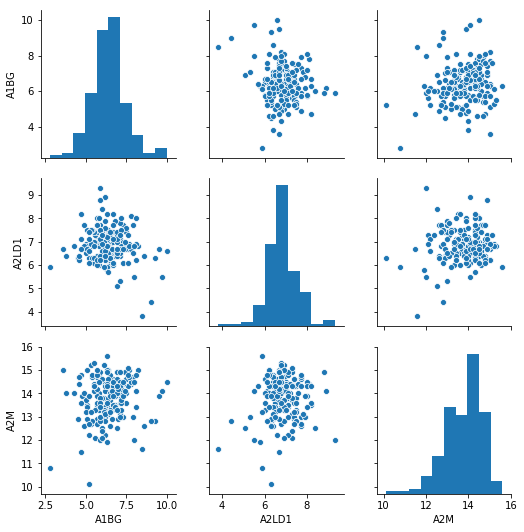

In [4]:
sns.pairplot(df.T.iloc[:, [1,4,6]])

### Dropping columns with `NaN` values

Dropping columns seems like the most appropriate thing to do to get rid of `NaN` values. Doing it would reduce the number of columns (genes) from ~18,000 to ~14,000. 

Another alternative is to fill in the NaN by drawing values from a pdf obtained by fitting the data either using a non-parametric method like KDE, or to a parametric distribution. But doing this would mean drawing a value that's independent of the sample it belongs to, which defeats the purpose of analyzing the gene <--> sample relationship.

So for now I've just decided to drop the columns

In [5]:
clean_df = df.dropna(axis=0)
arr = clean_df.values

## PCA

PCA is sensitive to how the data is normalized. In the assignment description you say that the data contains "**normalized** RNASequencing reads". I've decided to do PCA using this normalized data in addition to copy of the dataset where the data has unit variance.

In [6]:
mean = np.mean(arr, axis=1)
std = np.std(arr, axis=1)
X_sdd, X = ((arr - np.expand_dims(mean, 1)) / np.expand_dims(std, 1)).T, arr.T
X.shape

(183, 14098)

**X**     : original dataset without NaN values

**X_sdd** : standardized dataset without NaN values

In [7]:
from sklearn.decomposition import PCA

In [8]:
pca, pca_sdd = PCA(copy=True), PCA(copy=True)
pca.fit(X), pca_sdd.fit(X_sdd)

(PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
 PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False))

<BarContainer object of 20 artists>

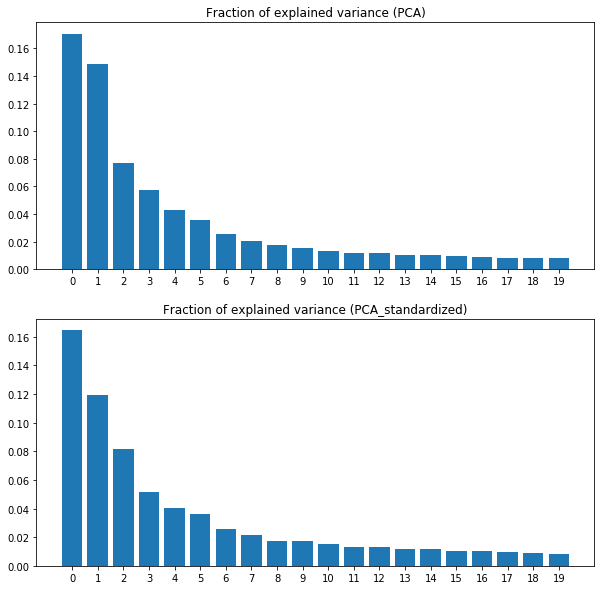

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.title("Fraction of explained variance (PCA)")
plt.bar([str(i) for i in range(20)], pca.explained_variance_ratio_[:20])


plt.subplot(2, 1, 2)
plt.title("Fraction of explained variance (PCA_standardized)")
plt.bar([str(i) for i in range(20)], pca_sdd.explained_variance_ratio_[:20], )

10 of the principal components explain 61% of the variance in the data

In [10]:
pca.explained_variance_ratio_[0:10].sum()

0.61180166409773484

Overlaying 'histological_type_other' on the data

In [11]:
hto["Type"] = "NaN"
hto.loc[hto.histological_type_other.str.contains("neuroendocrine")==True, "Type"] = "Neuroendocrine"
hto.loc[hto.histological_type_other.str.contains("adenocarcinoma")==True, "Type"] = "Adenocarcinoma"

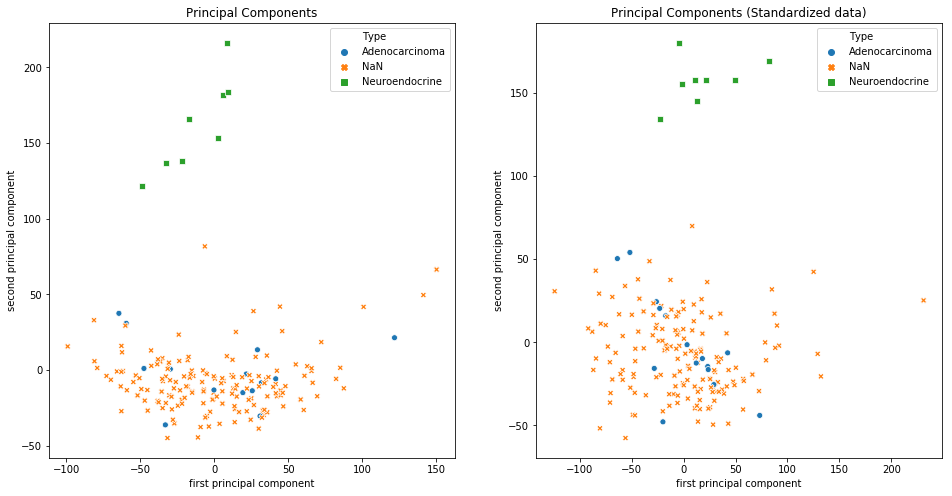

In [12]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
t1, t2 = list(pca.transform(X)[:, 0:2].T)
ax1 = sns.scatterplot(t1, t2, hue=hto["Type"],style=hto["Type"])
ax1.set_title("Principal Components")
ax1.set_xlabel("first principal component")
ax1.set_ylabel("second principal component")

plt.subplot(1, 2, 2)
t1, t2 = list(pca_sdd.transform(X_sdd)[:, 0:2].T)
ax2 = sns.scatterplot(t1, t2, hue=hto["Type"],style=hto["Type"])
ax2.set_title("Principal Components (Standardized data)")
ax2.set_xlabel("first principal component")
ax2.set_ylabel("second principal component")
None

The samples form ~2 clusters. The neuroendocrine samples are seperating out from the rest. 

### Interferons

In [15]:
with open("type1_IFN.txt", "r") as f:
    type1_IFN = [line[:-1] for line in  f.readlines()]

type1_IFN

['IFIT1',
 'IFI44',
 'IFIT3',
 'MX2',
 'OAS1',
 'OAS3',
 'BST2',
 'IFITM1',
 'MX1',
 'STAT1',
 'IFI27',
 'CXCL10',
 'IFI16',
 'IFI30',
 'IFIH1',
 'IFIT2',
 'IFITM2',
 'IRF1',
 'IRF9',
 'IRGM',
 'ISG15',
 'OAS2',
 'PSME1',
 'SOCS1',
 'STAT2']

In [14]:
adenocarcinoma_samples = list(hto[hto["Type"]=="Adenocarcinoma"].index)
adenocarcinoma_samples

['aab1-Primary solid Tumor',
 'aabh-Primary solid Tumor',
 'aabi-Primary solid Tumor',
 '6879-Primary solid Tumor',
 'a45n-Solid Tissue Normal',
 'a45n-Primary solid Tumor',
 '7289-Primary solid Tumor',
 '8519-Primary solid Tumor',
 'a4bk-Primary solid Tumor',
 'a77p-Primary solid Tumor',
 'a77q-Primary solid Tumor',
 'a9tj-Metastatic',
 'a9tj-Primary solid Tumor',
 'a77e-Primary solid Tumor',
 'a8t5-Primary solid Tumor']

In [16]:
clean_df.loc[:, adenocarcinoma_samples].to_csv("expression_df.csv")

In [17]:
gene_set = clean_df.reindex(index=type1_IFN, columns=adenocarcinoma_samples)
print(gene_set.shape)
gene_set

(25, 15)


cid,aab1-Primary solid Tumor,aabh-Primary solid Tumor,aabi-Primary solid Tumor,6879-Primary solid Tumor,a45n-Solid Tissue Normal,a45n-Primary solid Tumor,7289-Primary solid Tumor,8519-Primary solid Tumor,a4bk-Primary solid Tumor,a77p-Primary solid Tumor,a77q-Primary solid Tumor,a9tj-Metastatic,a9tj-Primary solid Tumor,a77e-Primary solid Tumor,a8t5-Primary solid Tumor
rid,,,,,,,,,,,,,,,
IFIT1,9.5,8.5,7.2,10.4,10.0,9.2,3.2,9.7,10.1,9.2,9.7,8.6,9.5,10.4,9.4
IFI44,9.4,8.6,7.9,10.5,11.2,9.5,4.1,8.9,10.1,9.2,10.4,8.9,9.8,10.9,9.3
IFIT3,10.0,9.1,9.1,10.8,10.9,9.8,7.3,9.8,10.5,9.3,10.1,8.9,9.5,10.1,9.6
MX2,9.8,9.2,9.2,11.1,11.4,9.2,10.0,8.9,9.8,9.5,10.7,9.2,9.7,10.9,9.7
OAS1,11.7,8.9,7.5,12.0,10.7,10.5,10.5,10.3,11.7,10.0,10.8,8.7,9.4,10.7,9.5
OAS3,11.3,10.1,9.5,12.3,11.4,10.6,10.2,10.6,11.1,9.8,11.7,10.1,10.6,11.7,10.0
BST2,12.2,9.9,10.8,13.2,12.1,11.5,12.0,10.4,11.9,11.1,12.5,10.6,10.3,12.2,12.0
IFITM1,11.2,9.7,10.6,12.7,12.3,11.3,10.5,11.2,11.9,11.2,12.7,9.8,11.2,12.7,12.1
MX1,11.5,10.7,10.4,12.7,12.7,10.9,8.4,10.4,11.8,10.9,12.0,10.4,11.3,12.4,10.8


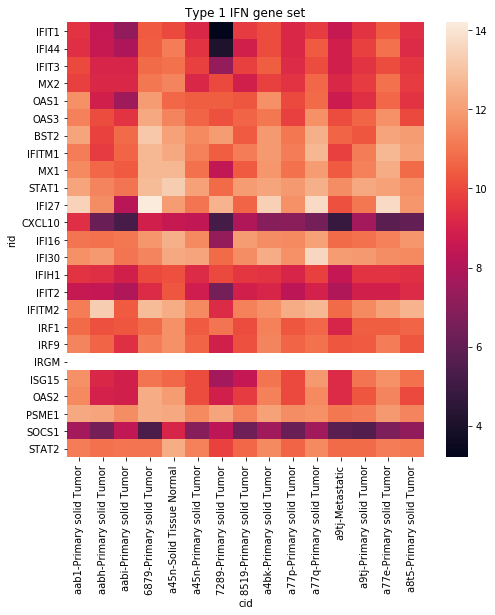

In [19]:
plt.figure(figsize=(8,8))
sns.heatmap(gene_set).set_title("Type 1 IFN gene set")
None

In [20]:
# gmt file to be used as input for the GSVA software
with open("type1_IFN.gmt", "w") as f:
    for gene in type1_IFN:
        f.write("{0}\tnodescription\t{0}\n".format(gene))

Ran the following in docker (https://hub.docker.com/r/vacation/gsva)
```
GSVA --gmt type1_IFN.gmt expression_df.csv --output output.csv
```

In [21]:
# Reading the output of the GSVA algorithm
output = pd.read_csv("output.csv")
output.index = output.name
output.drop(columns=["name"], inplace=True)

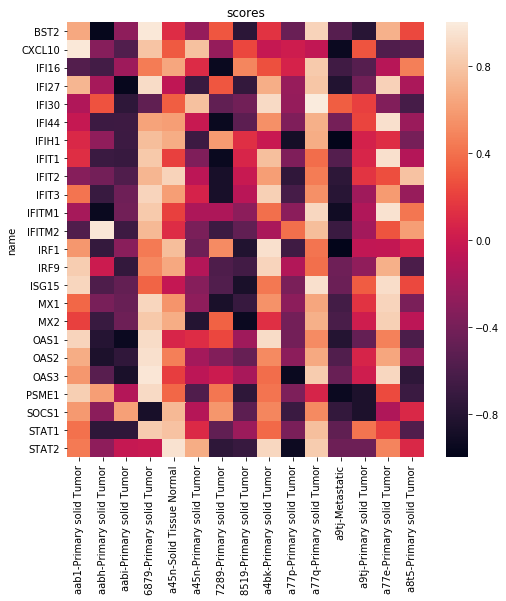

In [22]:
plt.figure(figsize=(8,8))
sns.heatmap(output).set_title("scores")
None

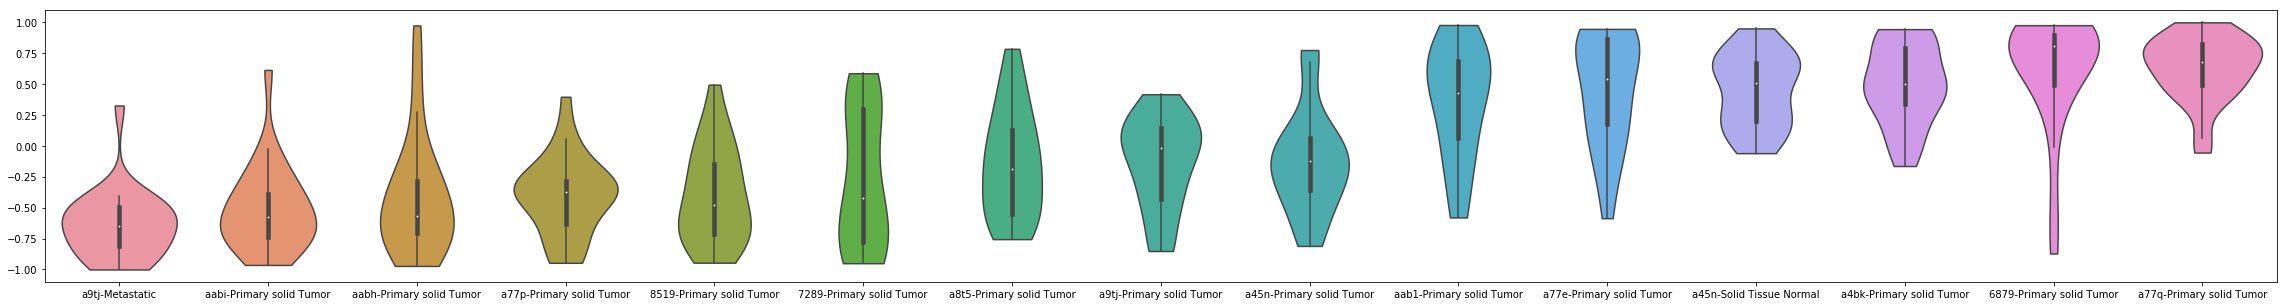

In [23]:
plt.figure(figsize=(40,5))
sns.violinplot(data=output[list(output.mean().sort_values().index)], cut=0)
None

The samples are **loosely** forming two groups based on the mean of their scores.